<a id="a1"></a>
# Import the necessary libraries

In [ ]:
!pip install -U scikit-learn
!pip install ydata-profiling

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

import ydata_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set(style="whitegrid")
%matplotlib inline
from scipy.stats import zscore
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import requests
from io import StringIO

#setting up for customized printing
from IPython.display import Markdown, display
from IPython.display import HTML
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

#function to display dataframes side by side
from IPython.display import display_html
def display_side_by_side(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline;margin-left:50px !important;margin-right: 40px !important"'),raw=True)

In [ ]:
def distancePlot(fRows,fCols,xSize, ySize, data, features, colors, kde=True, bins=None):
    f, axis = plt.subplots(fRows, fCols, figsize=(xSize, ySize))

    features = np.array(features).reshape(fRows, fCols)
    colors = np.array(colors).reshape(fRows, fCols)

    for row in range(fRows):
        for col in range(fCols):
            if (fRows == 1 and fCols == 1) :
                axisPolt = axis
            elif (fRows == 1 and fCols > 1) :
                axisPolt = axis[col]
            elif (fRows > 1 and fCols == 1) :
                axisPlot = axis[row]
            else:
                axisPlot = axis[row][col]
            plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axisPolt, kde=kde, hist_kws={"edgecolor":"k"})
            plot.set_xlabel(features[row][col],fontsize=20)

In [ ]:
def scatterplot(rFeature, cFeature, data):
    f, axis = plt.subplots(1, 1, figsize=(10, 8))

    plot=sns.scatterplot(x=rFeature, y=cFeature, data=data, ax=axis)
    plot.set_xlabel(rFeature,fontsize=20)
    plot.set_ylabel(cFeature,fontsize=20)

<a id="a2"></a>
# Read the data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
products = '/content/drive/My Drive/product_ratings.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import io

products = pd.read_csv(products, names=['userId', 'productId', 'rating','timestamp', 'mapped_userId', 'mapped_productId','sentiment', 'product_review'], header=None)

# Now the 'products' DataFrame should be the same as the csv you have
print(products.head())

           userId   productId  rating   timestamp  mapped_userId  \
0          userId   productId  rating   timestamp  mapped_userId   
1  A2CX7LUOHB2NDG  0321732944       5  1341100800              0   
2  A2NWSAGRHCP8N5  0439886341       1  1367193600              1   
3  A2WNBOD3WNDNKT  0439886341       3  1374451200              2   
4  A1GI0U4ZRJA8WN  0439886341       1  1334707200              3   

   mapped_productId  sentiment  \
0  mapped_productId  sentiment   
1                 0   positive   
2                 1   positive   
3                 1   negative   
4                 1   positive   

                                      product_review  
0                                     product_review  
1  Very satisfied with my purchase. The product i...  
2  Encountered multiple problems with this item. ...  
3  The product is decent, but there are some issu...  
4  Very disappointed with this purchase. The prod...  


<a id="a3"></a>
# Attributes and other Information on the data

1. **userId** : Every user identified with a unique id<br>
2. **productId** : Every product identified with a unique id<br>
3. **rating** : Rating of the corresponding product by the corresponding user<br>
4. **timestamp** : Time of the rating
5. **mapped_userId** : String UserID mapped to an integer value
6. **mapped-productId** : String productID mapped to an integer value
7. **sentiment** : setiment of the product review comment
8. **product_review** : Product review consistent with the user rating and sentiment



<a id="a4"></a>
# Basic Exploratory Data Analysis

<a id="a4a"></a>
## a. Drop attributes that are not needed

In [ ]:
products.drop('timestamp', axis=1, inplace=True)
products.drop('sentiment', axis=1, inplace=True)
products.drop('product_review', axis=1, inplace=True)
products.drop('mapped_userId', axis=1, inplace=True)
products.drop('mapped_productId', axis=1, inplace=True)

In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [ ]:
products.head()

,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


<a id="a4c"></a>
## b. Filtering the data and creating a Subset

**Keeping only those users who have given 50 or more number of ratings**

In [ ]:
products_group_users_Ratings = products.groupby('userId')['rating']
products_group_users_Ratings = pd.DataFrame(products_group_users_Ratings.count())

In [ ]:
user_list_min50_ratings = products_group_users_Ratings[products_group_users_Ratings['rating'] >= 50].index
products =  products[products['userId'].isin(user_list_min50_ratings)]

<a id="a4c"></a>
## c. Shape of the data

In [ ]:
print('The total number of rows :', products.shape[0])
print('The total number of columns :', products.shape[1])

The total number of rows : 125871
The total number of columns : 3


<a id="a4d"></a>
## c. Data type of each attribute

In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125871 entries, 94 to 7824444
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     125871 non-null  object 
 1   productId  125871 non-null  object 
 2   rating     125871 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.8+ MB


<a id="a4d"></a>
## d. Presence of Null values

In [ ]:
display(products.isna().sum().sort_values())
printmd('**CONCLUSION**: The data above has **"No Missing"** values')

userId       0
productId    0
rating       0
dtype: int64

<span style='color:None'>**CONCLUSION**: The data above has **"No Missing"** values</span>

<a id="a4f"></a>
## e. 5 point summary of numerical attributes

In [ ]:
display(products[['rating']].describe().transpose())

,count,mean,std,min,25%,50%,75%,max
rating,125871.0,4.261339,1.062144,1.0,4.0,5.0,5.0,5.0


<a id="a4g"></a>
## f. Number of Unique Users and Products Count

In [ ]:
print('Total unique users in the dataset', products['userId'].nunique())
print('Total unique products in the dataset', products['productId'].nunique())

Total unique users in the dataset 1540
Total unique products in the dataset 48190


<a id="a5"></a>
# Data Visualization and Data Analysis

<a id="a5a"></a>
## a. Rating Distribution

In [ ]:
palet = sns.color_palette(palette='Set1', n_colors=16)

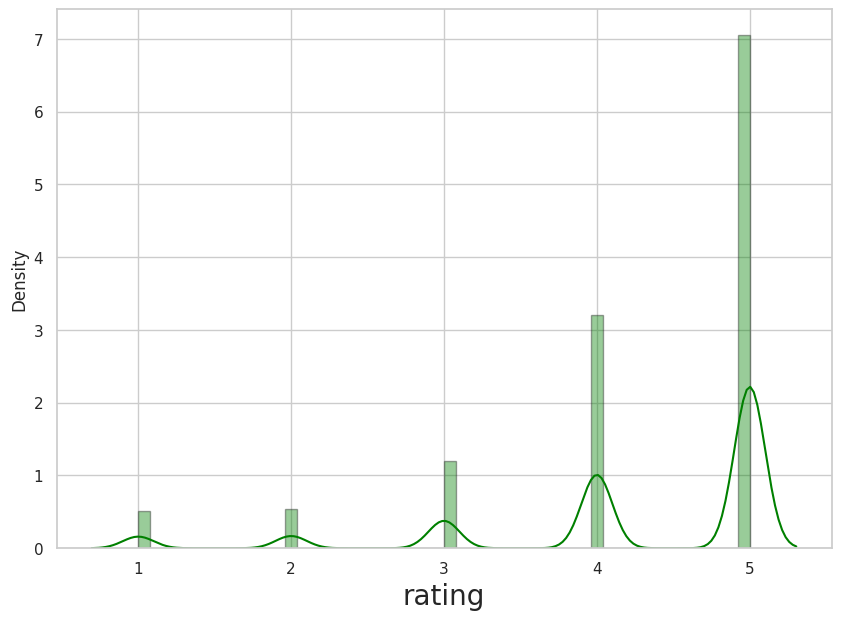

In [ ]:
distancePlot(1, 1, 10, 7, data=products, features=['rating'], colors=['green'])

### Observations

1. Quite large set of uers have given a 5 rating
2. Followed by rating 5
3. The lower ratings are comparitively less in usage

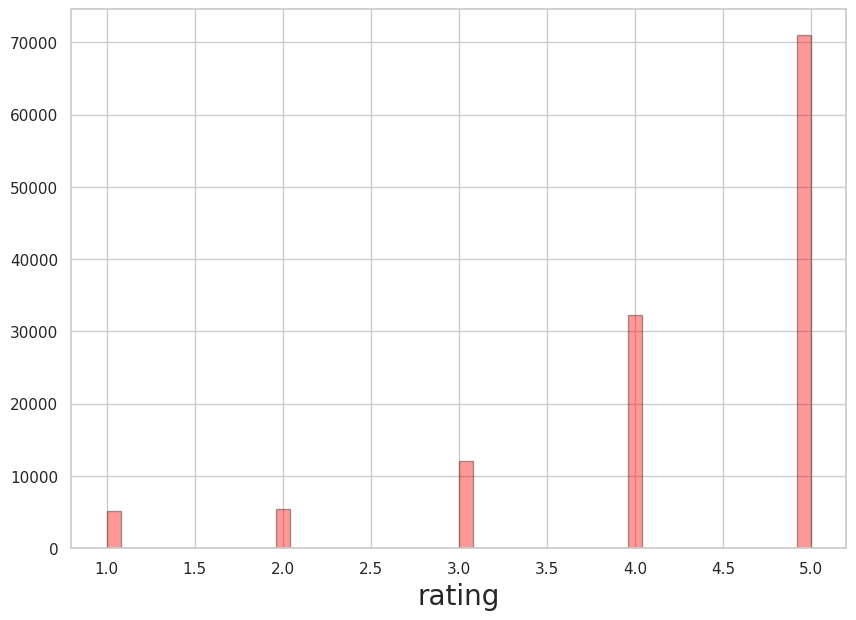

In [ ]:
distancePlot(1, 1, 10, 7, data=products, features=['rating'], colors=['red'], kde=False)

### Observations

1. About 70,000 uer have given a 5 star rating to rpoducts
2. Followed by rating 4 with a value of more than 30,000.
3. More than 10k users have rated 3.
4. Boths rating 1 and 2 have below 10k records.

<a id="a5b"></a>
## b. Top Rating Count Distribution grouped by Products

In [ ]:
products_group_products_Ratings = products.groupby('productId')['rating']

In [ ]:
products_group_products_Ratings.count().clip(upper=30).unique()

array([ 1,  2,  4,  6,  5,  8,  3,  7, 12,  9, 17, 16, 10, 13, 21, 19, 11,
       18, 14, 30, 15, 28, 23, 29, 24, 22, 25, 20, 26, 27])

In [ ]:
ratings_products = pd.DataFrame(products_group_products_Ratings.count().clip(upper=30))
ratings_products.rename(columns={"rating": "rating_Count"}, inplace=True)

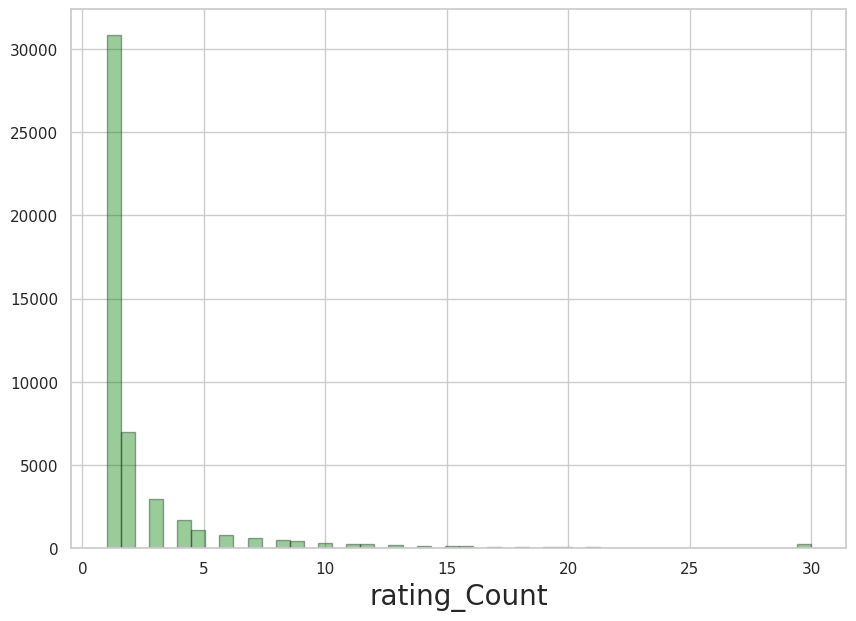

In [ ]:
distancePlot(1, 1, 10, 7, data=ratings_products, features=['rating_Count'], colors=['green'], kde=False)

### Observations

This is ratings count distribution grouped by all the Products.
There are a large portion of products which have been rated only once i.e. only one user have rated. And then the count decreases.

<a id="a5c"></a>
## c. Top Rating Count Distribution grouped by Users

In [ ]:
products_group_users_ratings = products.groupby('userId')['rating']

In [ ]:
products_group_users_ratings.count().clip(lower=50).unique()

array([116, 132,  68,  71,  65,  57,  96,  80, 107, 123,  77, 130,  52,
        89, 112,  67,  86,  66,  75, 205,  58,  50, 216,  92,  54,  64,
        51, 252,  72,  81,  74,  53,  62,  70, 104, 102,  60,  63, 157,
        99,  56,  55,  61, 261, 151,  94,  78, 119,  83,  73, 144, 177,
       149, 106,  82,  69, 108, 196,  76, 221, 197, 200, 155, 208, 207,
       181, 160, 213,  59, 103,  85,  98, 145, 218,  84, 101,  91, 100,
        88, 114,  79,  93, 131, 142, 380,  90,  95, 126, 110, 105,  97,
       167, 227, 128, 127, 247, 129, 220, 121,  87, 202, 109, 156, 111,
       162, 240, 125, 137, 150, 292, 270, 115, 226, 296, 311, 176, 170,
       122, 117, 159, 277, 238, 120, 253, 138, 171, 136, 314, 282, 236,
       257, 204, 146, 124, 174, 279, 118, 199, 209, 498, 266, 143, 169,
       134, 173, 147, 182, 163, 180, 153, 225, 520, 406, 431, 193, 139,
       501, 239, 244, 192, 141, 198, 212, 308, 168, 189])

In [ ]:
rating_users = pd.DataFrame(products_group_users_ratings.count().clip(lower=50, upper=300))
rating_users.rename(columns={"rating": "rating_Count"}, inplace=True)

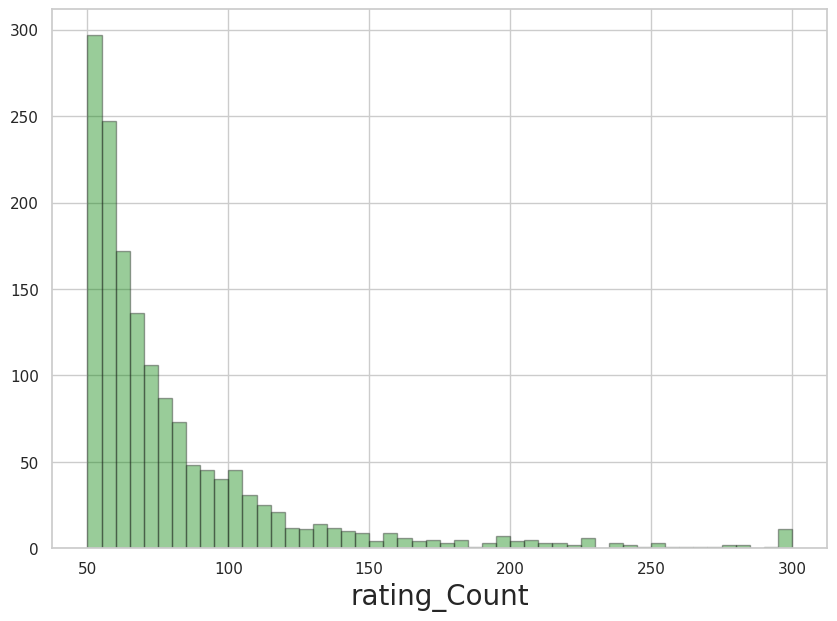

In [ ]:
distancePlot(1, 1, 10, 7, data=rating_users, features=['rating_Count'], colors=['green'], kde=False, bins=50)

### Observations

This is a ratings count distribution grouped by all the Users.
Huge chunk of users which have rated 50 times or less. Ratings count by users gradually decreases which means few users have rated many products.

<a id="a5d"></a>
## d. Mean Rating Distribution grouped by Products

In [ ]:
ratings = pd.DataFrame(products.groupby('productId')['rating'].mean())
ratings.rename(columns={"rating": "rating_Mean"}, inplace=True)

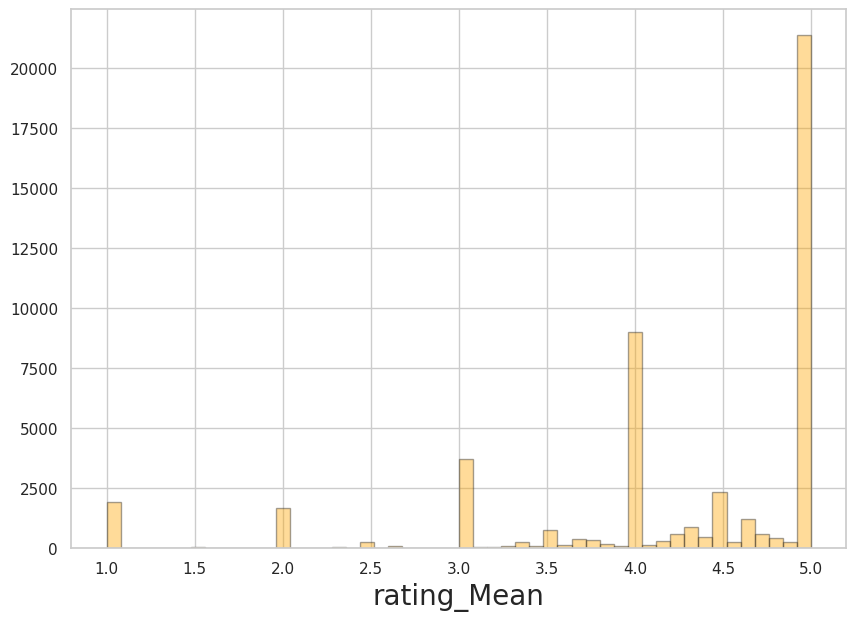

In [ ]:
distancePlot(1, 1, 10, 7, data=ratings, features=['rating_Mean'], colors=['orange'], kde=False, bins=50)

### Observations

This is a mean rating distribution grouped by all the Products. There are many products which were given a Rating of 4 or 5. Hence the plot shows lot of bins between 4 and 5.

<a id="a5e"></a>
## e. Mean Rating - Rating Count Distribution grouped by Products

In [ ]:
ratings['rating_Count'] = products.groupby('productId')['rating'].count()

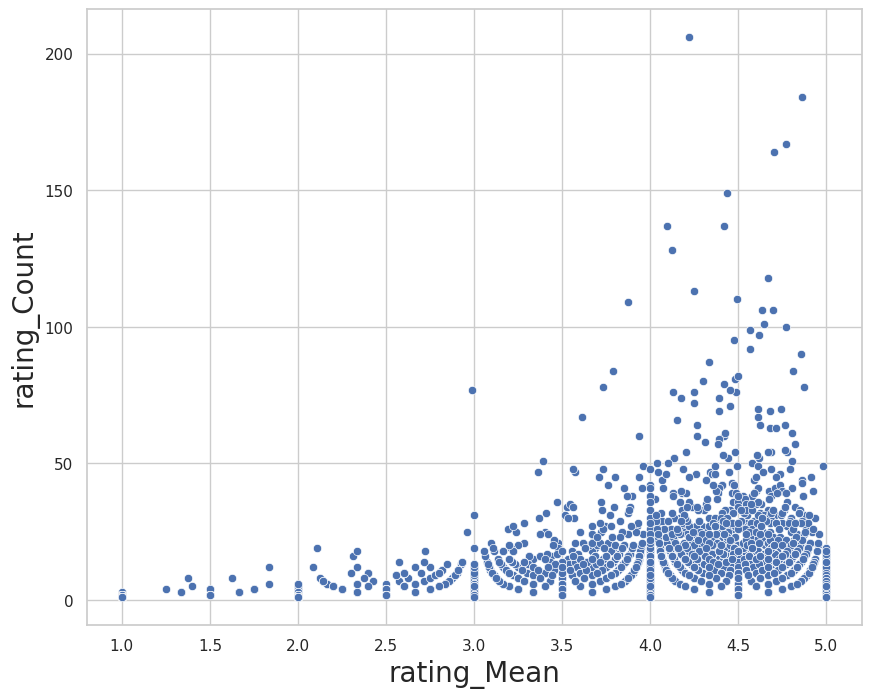

In [ ]:
scatterplot('rating_Mean', 'rating_Count', data=ratings)


### Observations

This is a joint plot between Mean rating distribution and Rating Count grouped by all the Products. We can see that the data is clustered between mean rating of 3.5 to 5 and the density reduces in the lower ratings.

<a id="a5f"></a>
## f. Mean Rating Distribution grouped by Users

In [ ]:
ratings = pd.DataFrame(products.groupby('userId')['rating'].mean())
ratings.rename(columns={"rating": "rating_Mean"}, inplace=True)


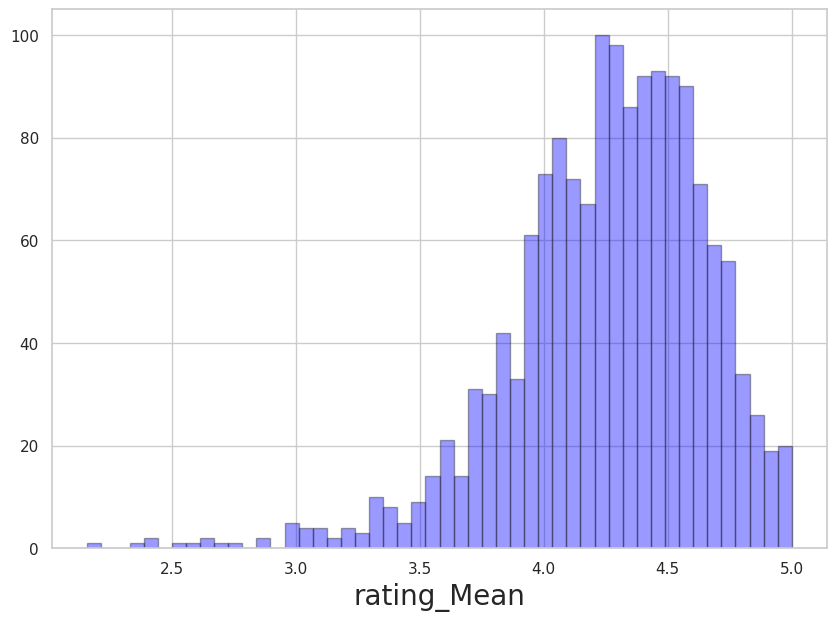

In [ ]:
distancePlot(1, 1, 10, 7, data=ratings, features=['rating_Mean'], colors=['blue'], kde=False, bins=50)

### Observations

This is a mean rating distribution grouped by all the Users. This graph shows that the data is slightly left skewed normal distribution.

Uniformly distribution from rating 3 to 5 with many around 4 to 4.5. Most of the users have an average rating of about 4.5.

<a id="a5g"></a>
## g. Mean Rating - Rating Count Distribution grouped by Users

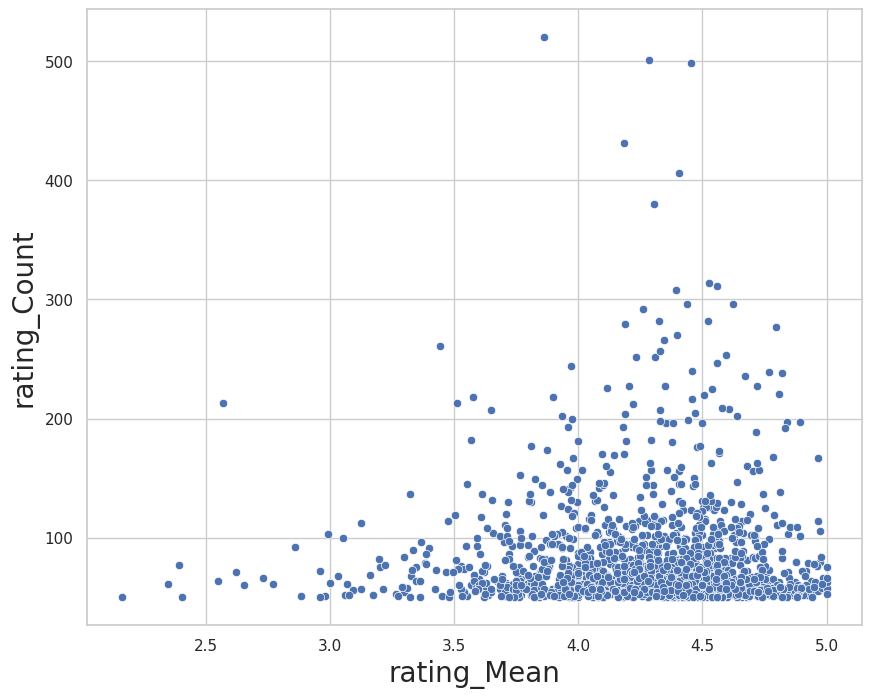

In [ ]:
ratings['rating_Count'] = products.groupby('userId')['rating'].count()
scatterplot('rating_Mean', 'rating_Count', data=ratings)

### Observations

This is a joint plot between Mean rating distribution and Rating Count grouped by all the Users. We can see that the data is clustered between 3.5 to 5. There are many data points when the Rating count is less than 100 and the mean rating for the users is between 3.5 and 5. The graph density reduces for lower rating between 1-3.